In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import warnings
from pathlib import Path
from pandas import date_range

import pycompo.core.composite as pccompo
import pycompo.core.utils as pcutil
import pycompo.core.plot as pcplot

warnings.filterwarnings(action='ignore')

# read in configuration file
config_file = "/home/m/m300738/libs/pycompo/config/settings_ngc5004_pc03.yaml"
config = pcutil.read_yaml_config(config_file)

start_time = config['data']['analysis_time'][0]
end_time = config['data']['analysis_time'][1]
analysis_times = [
    np.datetime64(t) for t in date_range(
        np.datetime64(start_time), np.datetime64(end_time), freq='MS',
        )
    ]
subgroup_vars = config['composite']['subgroup_vars']
analysis_idf = f"{config['exp']}_{config['pycompo_name']}"

# Calculate composites

### Preparations for composite subsampling

In [ ]:
analysis_times = analysis_times[:3] # Necessary since otherwise too long calculation time

# load feature_props
inpath = Path(f"{config['data']['outpath']}/{analysis_idf}/")
infile = Path(f"{analysis_idf}_feature_props_alltrops_all.nc")
feature_props_alltrops = xr.open_dataset(str(inpath/infile))
feature_props_alltrops_quartiles = feature_props_alltrops.quantile(
    [0.25, 0.50, 0.75]
    )

# build rainbelt if necessary
if config['composite']['rainbelt_subsampling']['switch']:
    rainbelt = pccompo.get_rainbelt(analysis_times, config, quantile=0.8)
    rainbelt = rainbelt.compute()
    infile = Path(f"{analysis_idf}_feature_props_rainbelt_all.nc")
    feature_props_rainbelt = xr.open_dataset(str(inpath/infile))
    feature_props_rainbelt_quartiles = feature_props_rainbelt.quantile(
        [0.25, 0.50, 0.75]
        )

### Read in feature_data

In [ ]:
# ------------------------------------------------------------------------------
# create a single feature composite
# ---------------------------------
inpath = Path(f"{config['data']['outpath']}/{analysis_idf}/features/")
alltrops_compo = []
alltrops_quartile_compo = {var: [] for var in subgroup_vars}
if config['composite']['rainbelt_subsampling']['switch']:
    rainbelt_compo = []
    rainbelt_quartile_compo = {var: [] for var in subgroup_vars}

for i in range (len(analysis_times)-1):
    # read in data
    file_timestr = \
        f"{pcutil.np_datetime2file_datestr(analysis_times[i])}-" + \
        f"{pcutil.np_datetime2file_datestr(analysis_times[i+1])}"
    infile = inpath/Path(f"{analysis_idf}_features_{file_timestr}.nc")
    features_alltrops = xr.open_dataset(infile).compute()
    alltrops_compo.append(features_alltrops.mean(dim='feature'))
    
    # subsample based on BG conditions
    for var in subgroup_vars:
        alltrops_quartile_compo[var].append(
            pccompo.get_quartile_compos_per_ts(
                features_alltrops, feature_props_alltrops_quartiles[var], var,
                )
            )

    # Precipitation-based geographic subsampling
    if config['composite']['rainbelt_subsampling']['switch']:
        features_rainbelt = pccompo.sample_features_geomask(
            features_alltrops, rainbelt,
            )
        rainbelt_compo.append(features_rainbelt.mean(dim='feature'))
        
        # subsample based on BG conditions
        for var in subgroup_vars:
            rainbelt_quartile_compo[var].append(
                pccompo.get_quartile_compos_per_ts(
                    features_rainbelt, feature_props_alltrops_quartiles[var], var,
                    )
                )

    # Basin-based geographic subsampling
    # TODO: Implement basin-based geographical subsampling


alltrops_compo = xr.concat(alltrops_compo, dim='month').mean(dim='month')
for var in subgroup_vars:
    alltrops_quartile_compo[var] = pccompo.get_full_quartile_compos(
        alltrops_quartile_compo[var],
    )
        
if config['composite']['rainbelt_subsampling']['switch']:
    rainbelt_compo = xr.concat(rainbelt_compo, dim='month').mean(dim='month')
    for var in subgroup_vars:
        rainbelt_quartile_compo[var] = pccompo.get_full_quartile_compos(
            rainbelt_quartile_compo[var],
    )

# Read in composites

In [2]:
inpath = Path(f"{config['data']['outpath']}/{analysis_idf}/")
infile = Path(f"{analysis_idf}_composite_alltrops_all.nc")
alltrops_compo = xr.open_dataset(str(inpath/infile))

alltrops_quartile_compo = {}
rainbelt_quartile_compo = {}
for var in subgroup_vars:
    infile = Path(f"{analysis_idf}_composite_alltrops_{var}_quartiles.nc")
    alltrops_quartile_compo[var] = xr.open_dataset(str(inpath/infile))
        
if config['composite']['rainbelt_subsampling']['switch']:
    infile = Path(f"{analysis_idf}_composite_rainbelt_all.nc")
    rainbelt_compo = xr.open_dataset(str(inpath/infile))
    
    for var in subgroup_vars:
        infile = Path(f"{analysis_idf}_composite_rainbelt_{var}_quartiles.nc")
        rainbelt_quartile_compo[var] = xr.open_dataset(str(inpath/infile))

### Visualization of composites

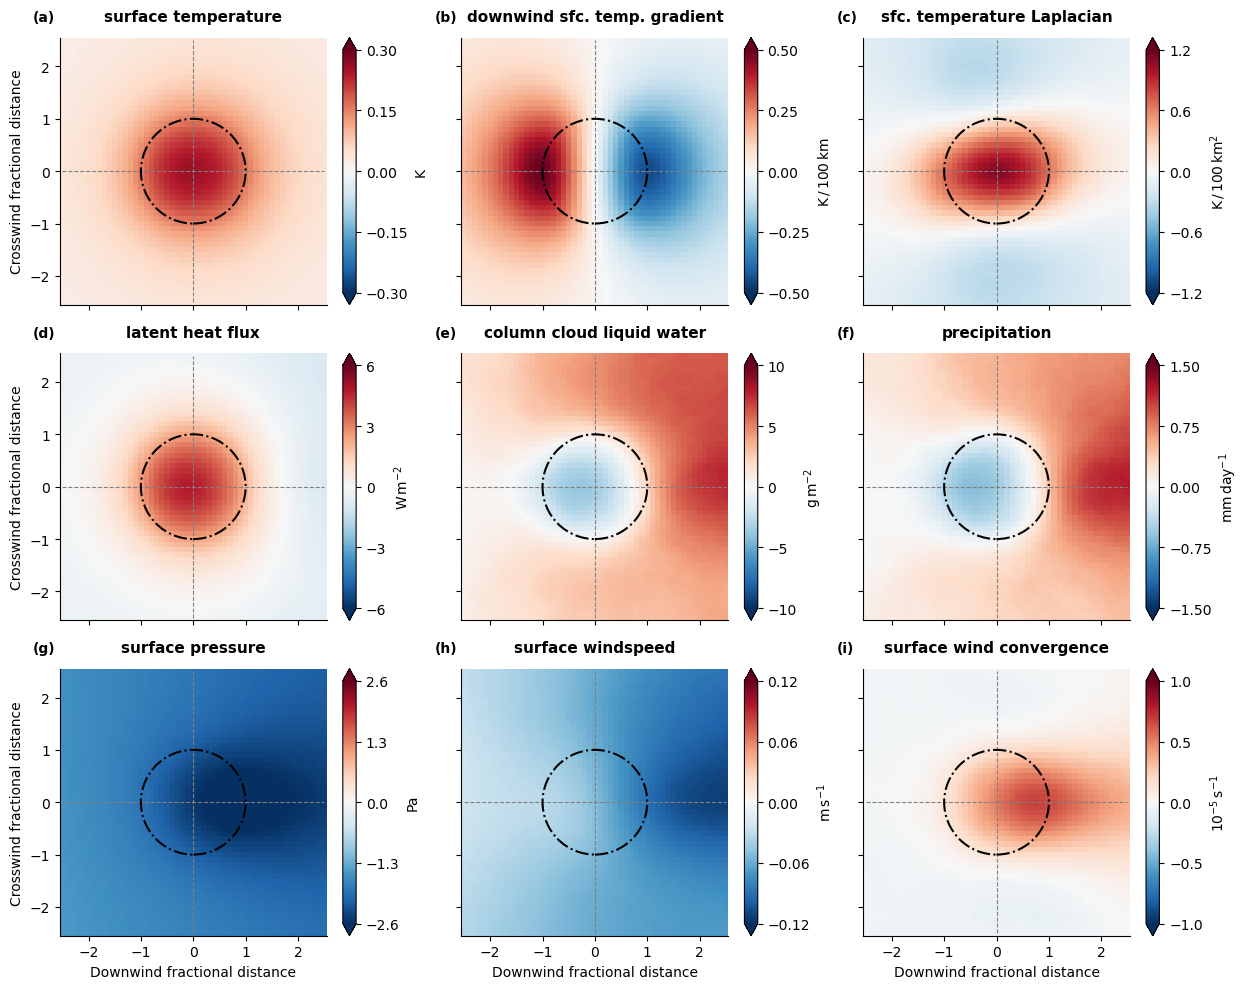

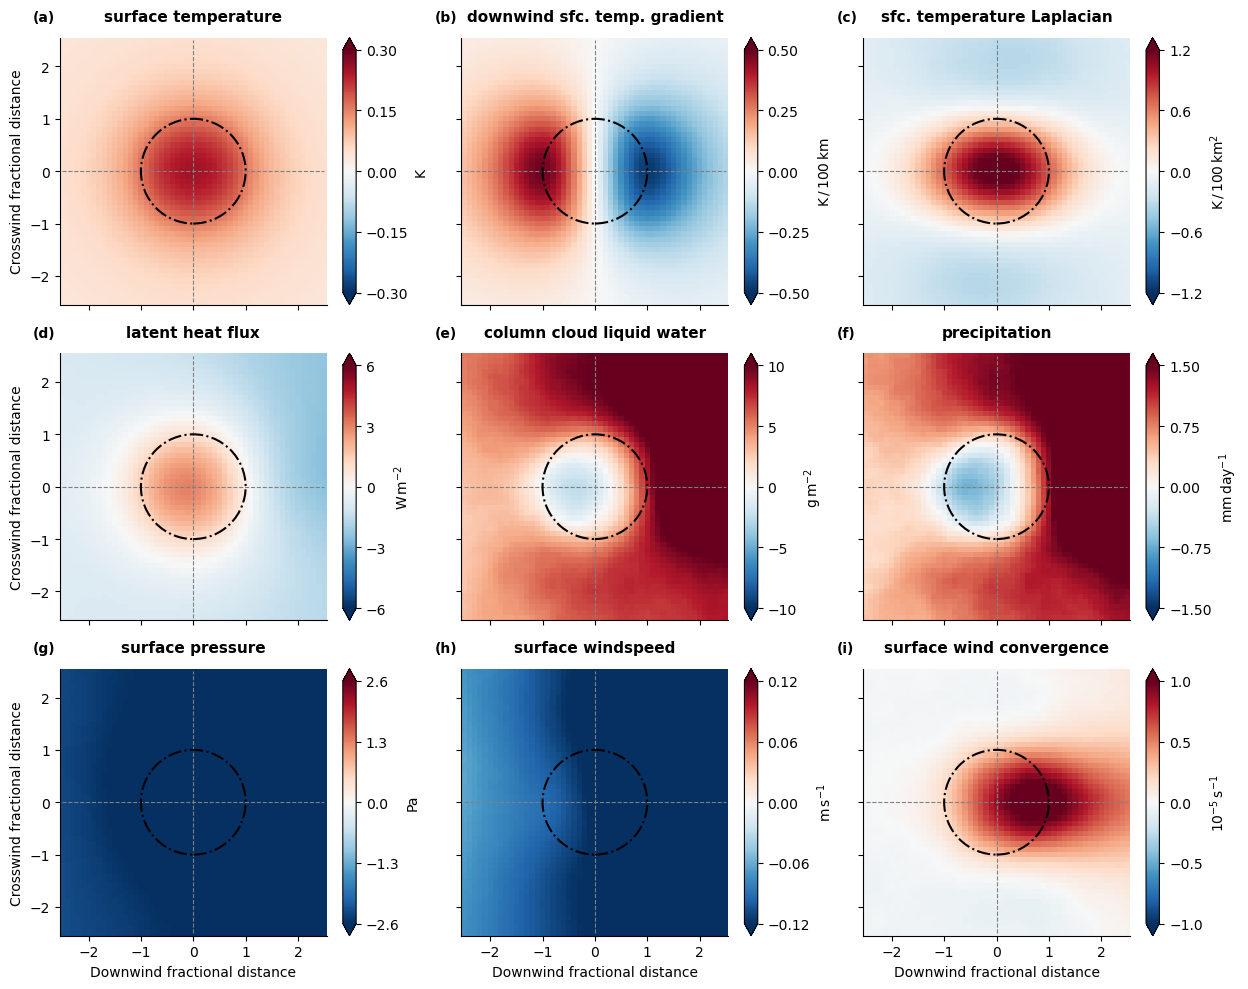

In [3]:
import importlib as implib
implib.reload(pcplot)

vars = [
    'ts_ano', 'downwind_ts_ano_grad', 'ts_ano_laplacian', 'hfls_ano',
    'cllvi_ano', 'pr_ano', 'ps_ano', 'sfcwind_ano', 'sfcwind_conv_ano',
    ]

alltrops_compo_adjusted = pccompo.adjust_units(alltrops_compo, vars)
pcplot.plot_composite_overview(alltrops_compo_adjusted, vars)
plt.savefig(
    '/home/m/m300738/project_TRR181L4/plots/sst_feature_composites/' +
    'composite_alltrops_overview.png', dpi=600,
    )

rainbelt_compo_adjusted = pccompo.adjust_units(rainbelt_compo, vars)
pcplot.plot_composite_overview(rainbelt_compo_adjusted, vars)
plt.savefig(
    '/home/m/m300738/project_TRR181L4/plots/sst_feature_composites/' +
    'composite_rainbelt_overview.png', dpi=600,
    )

### Plot subgroup composites

In [ ]:
import importlib as implib
implib.reload(pcplot)

vars = [
    'ts_ano', 'downwind_ts_ano_grad', 'ts_ano_laplacian', 'hfls_ano',
    'cllvi_ano', 'pr_ano', 'ps_ano', 'sfcwind_ano', 'sfcwind_conv_ano',
    ]

for var in subgroup_vars:
    for i in range(1, 5):
        alltrops_quartile_compo_adjusted = pccompo.adjust_units(
            alltrops_quartile_compo[var].sel(quartile=i), vars,
            )
        pcplot.plot_composite_overview(alltrops_quartile_compo_adjusted, vars)
        plt.savefig(
            f'/home/m/m300738/project_TRR181L4/plots/sst_feature_composites/' +
            f'composite_alltrops_{var}q{i}_overview.png', dpi=600,
            )
        
        rainbelt_quartile_compo_adjusted = pccompo.adjust_units(
            rainbelt_quartile_compo[var].sel(quartile=i), vars,
            )
        pcplot.plot_composite_overview(rainbelt_quartile_compo_adjusted, vars)
        plt.savefig(
            f'/home/m/m300738/project_TRR181L4/plots/sst_feature_composites/' +
            f'composite_rainbelt_{var}q{i}_overview.png', dpi=600,
            )

### Plot subgroup composites per variable

In [ ]:
import hfplot.figure.figure as hffig
import importlib as implib
implib.reload(pcplot)

vars = [
    'ts_ano', 'downwind_ts_ano_grad', 'ts_ano_laplacian', 'hfls_ano',
    'cllvi_ano', 'pr_ano', 'ps_ano', 'sfcwind_ano', 'sfcwind_conv_ano',
    'rlut_ano', 'prw_ano'
    ]
for var_plot in vars:
    fig, axs = hffig.init_subfig(
        style=None, asprat=(12.5, 13), nrow=4, ncol=3, sharex=True, sharey=True,
        )
    for v, var in enumerate(subgroup_vars):
        for i in range(0, 4):
            compo_data = pccompo.adjust_units(
                alltrops_quartile_compo[var].sel(quartile=i+1), vars,
                )

            if var_plot in ['hfls_ano', 'hfss_ano']:
                pl1 = axs[i, v].pcolormesh(
                    compo_data[var_plot]['En_rota2_featcen_x'],
                    compo_data[var_plot]['En_rota2_featcen_y'],
                    -1*compo_data[var_plot].transpose(),
                    cmap="RdBu_r", vmin=pcplot.COMPO_PLOT_RANGE[var_plot][0]*2.5,
                    vmax=pcplot.COMPO_PLOT_RANGE[var_plot][1]*2.5,
                )
            else:
                pl1 = axs[i, v].pcolormesh(
                    compo_data[var_plot]['En_rota2_featcen_x'],
                    compo_data[var_plot]['En_rota2_featcen_y'],
                    compo_data[var_plot].transpose(),
                    cmap="RdBu_r", vmin=pcplot.COMPO_PLOT_RANGE[var_plot][0]*2.5,
                    vmax=pcplot.COMPO_PLOT_RANGE[var_plot][1]*2.5,
                )
            pcplot._add_grid(
                axs[i, v],
                compo_data['En_rota2_featcen_x'], compo_data['En_rota2_featcen_y'],
                )
            pcplot._plot_feature_circle(axs[i, v], (0, 0), 1)
            axs[i, v].set_aspect('equal')
            axs[i, v].set_title(
                f"{var_plot},\n {var} q{i+1}", weight='bold', pad=12, fontsize=11,
                )
            #cbar_ticks = [
            #    COMPO_PLOT_RANGE[var][0], COMPO_PLOT_RANGE[var][0]/2, 0,
            #    COMPO_PLOT_RANGE[var][1]/2, COMPO_PLOT_RANGE[var][1], 
            #]
            plt.colorbar(
                pl1, ax=axs[i, v], label=pcplot.CLABEL_NICE[var_plot],
                extend='both', fraction=0.046, pad=0.05, #ticks=cbar_ticks,
                )
            hffig.set_label(
                axs, 'Downwind fractional distance', 'Crosswind fractional distance'
                )
        
    plt.tight_layout()
    plt.savefig(
        f'/home/m/m300738/project_TRR181L4/plots/sst_feature_composites/' +
        f'composite_alltrops_{var_plot}_quartiles_overview.png', dpi=600,
        )


In [ ]:
import hfplot.figure.figure as hffig
import importlib as implib
implib.reload(pcplot)

vars = [
    'ts_ano', 'downwind_ts_ano_grad', 'ts_ano_laplacian', 'hfls_ano',
    'cllvi_ano', 'pr_ano', 'ps_ano', 'sfcwind_ano', 'sfcwind_conv_ano',
    ]
for var_plot in vars:
    fig, axs = hffig.init_subfig(
        style=None, asprat=(12.5, 13), nrow=4, ncol=3, sharex=True, sharey=True,
        )
    for v, var in enumerate(subgroup_vars):
        for i in range(0, 4):
            compo_data = pccompo.adjust_units(
                rainbelt_quartile_compo[var].sel(quartile=i+1), vars,
                )

            if var_plot in ['hfls_ano', 'hfss_ano']:
                pl1 = axs[i, v].pcolormesh(
                    compo_data[var_plot]['En_rota2_featcen_x'],
                    compo_data[var_plot]['En_rota2_featcen_y'],
                    -1*compo_data[var_plot].transpose(),
                    cmap="RdBu_r", vmin=pcplot.COMPO_PLOT_RANGE[var_plot][0]*2.5,
                    vmax=pcplot.COMPO_PLOT_RANGE[var_plot][1]*2.5,
                )
            else:
                pl1 = axs[i, v].pcolormesh(
                    compo_data[var_plot]['En_rota2_featcen_x'],
                    compo_data[var_plot]['En_rota2_featcen_y'],
                    compo_data[var_plot].transpose(),
                    cmap="RdBu_r", vmin=pcplot.COMPO_PLOT_RANGE[var_plot][0]*2.5,
                    vmax=pcplot.COMPO_PLOT_RANGE[var_plot][1]*2.5,
                )
            pcplot._add_grid(
                axs[i, v],
                compo_data['En_rota2_featcen_x'], compo_data['En_rota2_featcen_y'],
                )
            pcplot._plot_feature_circle(axs[i, v], (0, 0), 1)
            axs[i, v].set_aspect('equal')
            axs[i, v].set_title(
                f"{var_plot},\n {var} q{i+1}", weight='bold', pad=12, fontsize=11,
                )
            #cbar_ticks = [
            #    COMPO_PLOT_RANGE[var][0], COMPO_PLOT_RANGE[var][0]/2, 0,
            #    COMPO_PLOT_RANGE[var][1]/2, COMPO_PLOT_RANGE[var][1], 
            #]
            plt.colorbar(
                pl1, ax=axs[i, v], label=pcplot.CLABEL_NICE[var_plot],
                extend='both', fraction=0.046, pad=0.05, #ticks=cbar_ticks,
                )
            hffig.set_label(
                axs, 'Downwind fractional distance', 'Crosswind fractional distance'
                )
        
    plt.tight_layout()
    plt.savefig(
        f'/home/m/m300738/project_TRR181L4/plots/sst_feature_composites/' +
        f'composite_rainbelt_{var_plot}_quartiles_overview.png', dpi=600,
        )


### Composite scatters

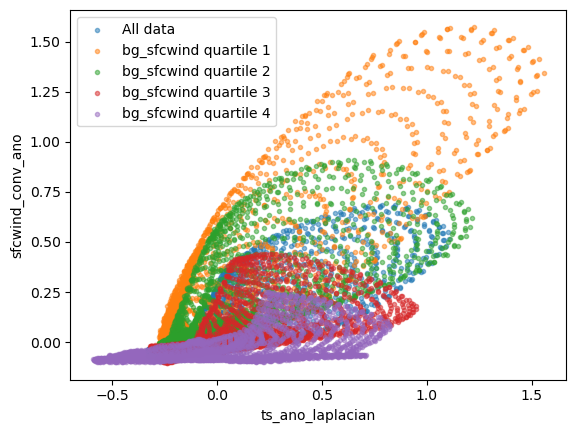

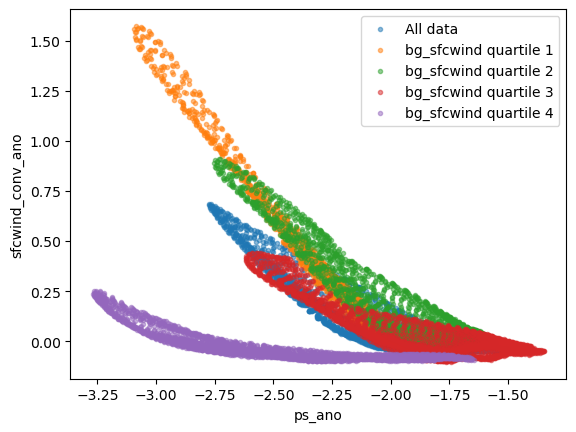

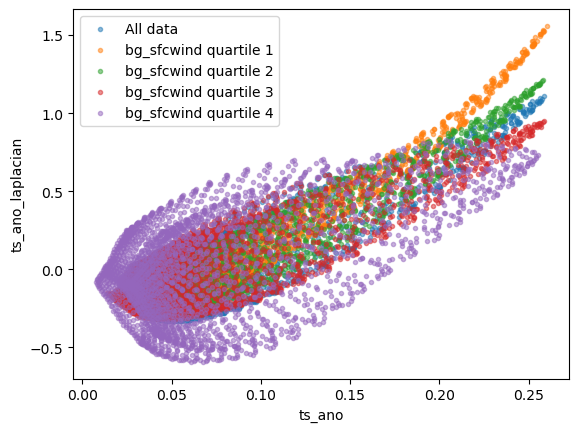

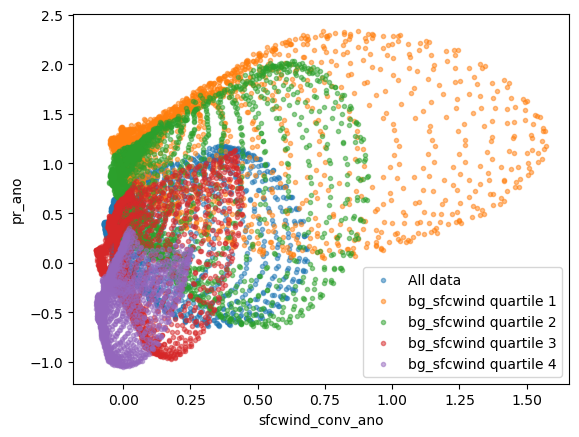

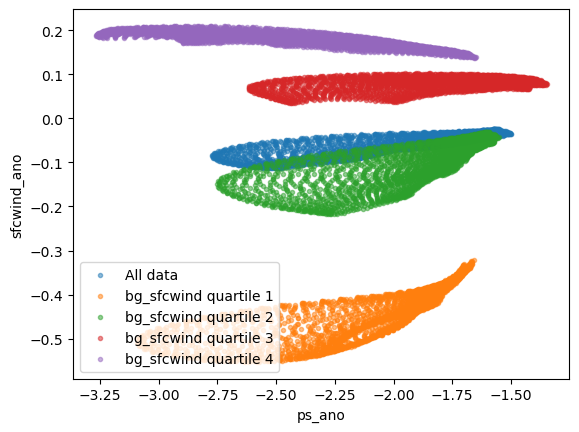

In [5]:
var_duo = [
    ('ts_ano_laplacian', 'sfcwind_conv_ano'),
    ('ps_ano', 'sfcwind_conv_ano'),
    ('ts_ano', 'ts_ano_laplacian'),
    ('sfcwind_conv_ano', 'pr_ano'),
    ('ps_ano', 'sfcwind_ano')
]
var_group = 'bg_sfcwind'
vars = [
    'ts_ano', 'downwind_ts_ano_grad', 'ts_ano_laplacian', 'hfls_ano',
    'cllvi_ano', 'pr_ano', 'ps_ano', 'sfcwind_ano', 'sfcwind_conv_ano',
    ]

for (x, y) in var_duo:
    alltrops_compo_adjusted = pccompo.adjust_units(alltrops_compo, vars)
    plt.scatter(
        alltrops_compo_adjusted[x], alltrops_compo_adjusted[y], label='All data',
        marker='.', alpha=0.5,
    )

    for i in range(0, 4):
        compo_data = pccompo.adjust_units(
            alltrops_quartile_compo[var_group].sel(quartile=i+1), vars,
            )
        plt.scatter(
        compo_data[x], compo_data[y], marker='.', alpha=0.5,
        label=f'{var_group} quartile {i+1}'
        )
        plt.legend()
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

### Testing

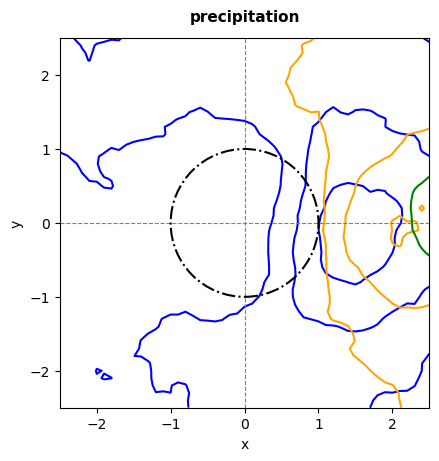

In [67]:
var = 'pr_ano'
colors = ['blue', 'orange', 'green', 'red']
for i in range(0, 4):
    compo_data = pccompo.adjust_units(
        alltrops_quartile_compo['bg_sfcwind'].sel(quartile=i+1), vars,
        )
    plt.contour(
        compo_data['En_rota2_featcen_x'], compo_data['En_rota2_featcen_y'],
        compo_data[var].transpose(), label=f'bg_sfcwind quartile {i+1}',
        colors=colors[i], levels=[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0],
    )
pcplot._add_grid(
    plt.gca(), compo_data['En_rota2_featcen_x'], compo_data['En_rota2_featcen_y'],
    )
pcplot._plot_feature_circle(plt.gca(), (0, 0), 1)
plt.gca().set_aspect('equal')
plt.gca().set_title(
    pcplot.COMPO_PLOT_LABEL[var], weight='bold', pad=12, fontsize=11,
    )
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Cuts along y=0

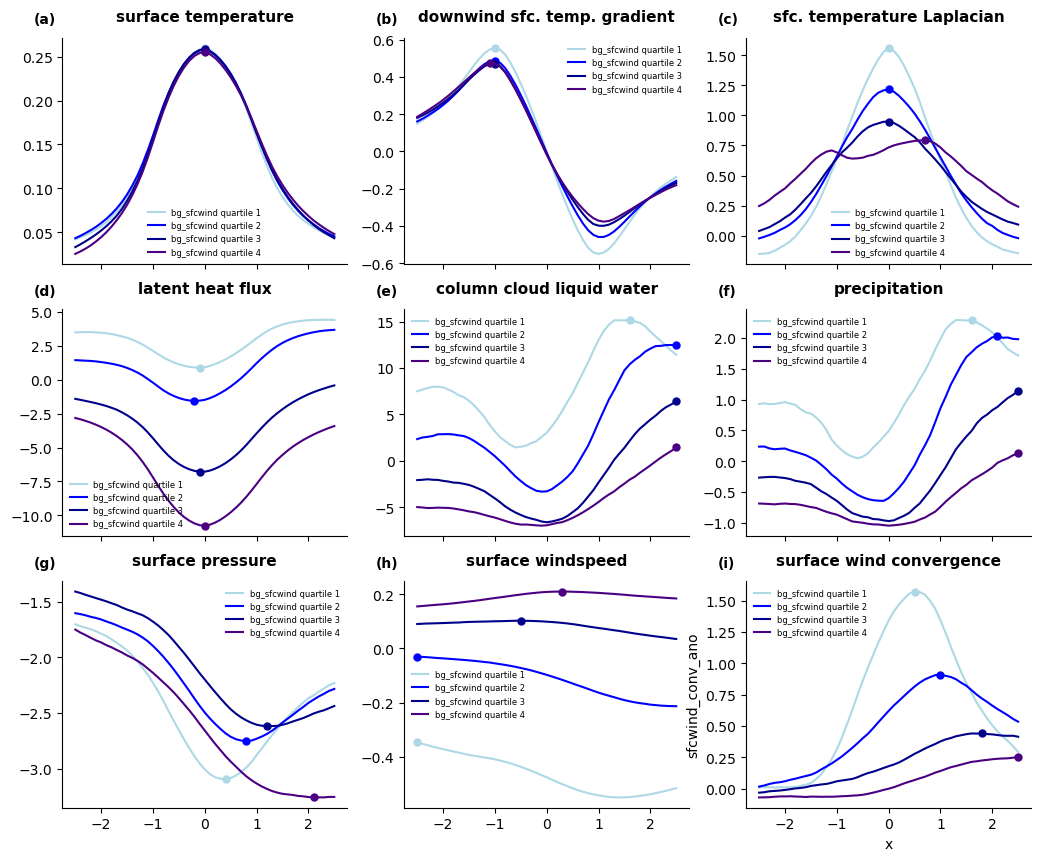

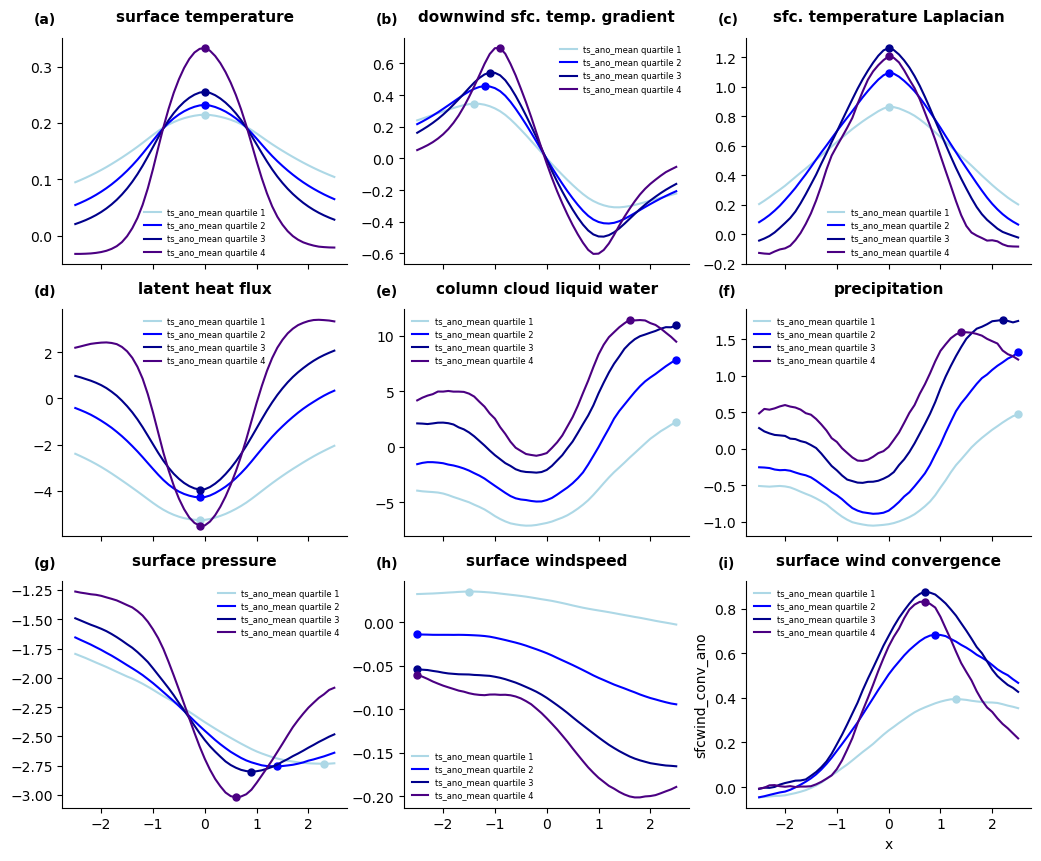

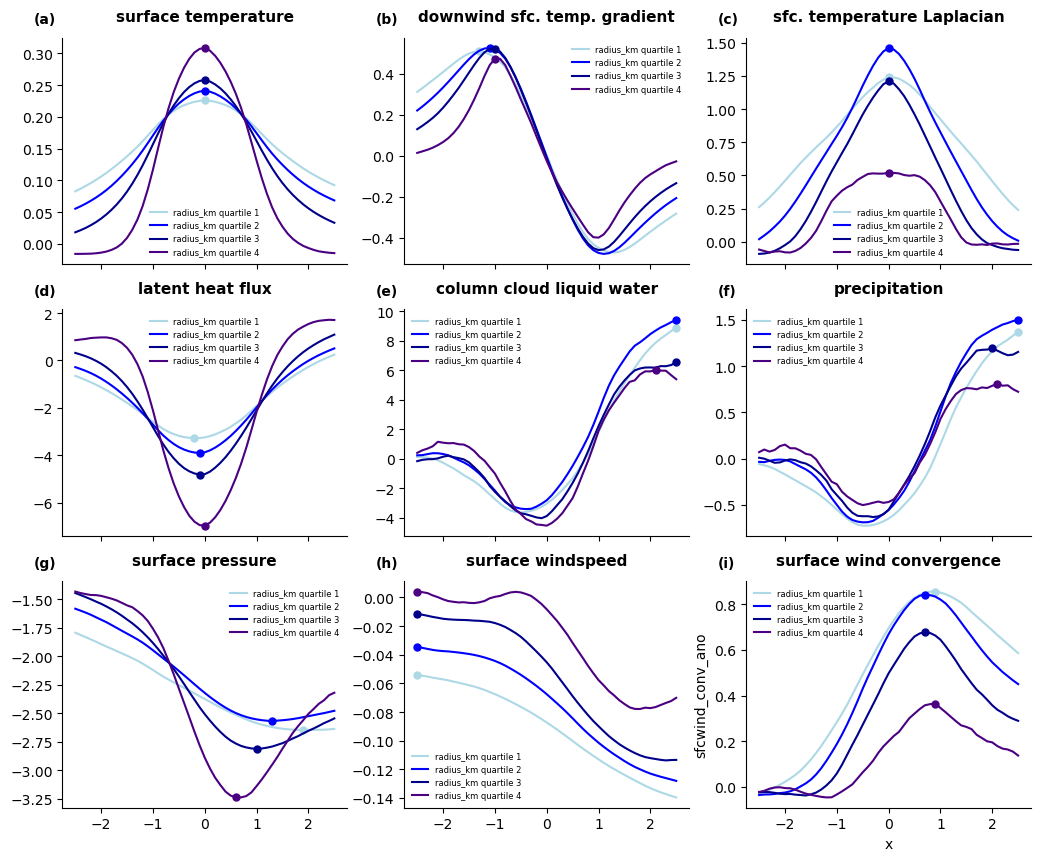

In [17]:
import hfplot.figure.figure as hffig
vars = [
    'ts_ano', 'downwind_ts_ano_grad', 'ts_ano_laplacian', 'hfls_ano',
    'cllvi_ano', 'pr_ano', 'ps_ano', 'sfcwind_ano', 'sfcwind_conv_ano',
    ]
colors = ['lightblue', 'blue', 'darkblue', 'indigo']

vars_group = ['bg_sfcwind', 'ts_ano_mean', 'radius_km']
for var_group in vars_group:
    fig, axs = hffig.init_subfig(
        style=None, asprat=(12.5, 10), nrow=3, ncol=3, sharex=True, sharey=False,
        )
    for v, var in enumerate(vars):
        for i in range(0, 4):
            compo_data = pccompo.adjust_units(
                alltrops_quartile_compo[var_group].sel(quartile=i+1), vars,
                ).sel(y=25)
            axs.ravel()[v].plot(
                compo_data['En_rota2_featcen_x'], compo_data[var],
                label=f'{var_group} quartile {i+1}', color=colors[i]
            )
            if var in ['hfls_ano', 'ps_ano']:
                axs.ravel()[v].plot(
                    compo_data['En_rota2_featcen_x'].isel(
                        x=compo_data[var].argmin(dim='x').item()
                        ),
                    compo_data[var].min(), '.', color=colors[i], markersize=10
                    )
            else:
                axs.ravel()[v].plot(
                    compo_data['En_rota2_featcen_x'].isel(
                        x=compo_data[var].argmax(dim='x').item()
                        ),
                    compo_data[var].max(), '.', color=colors[i], markersize=10
                    )
        axs.ravel()[v].set_title(
            pcplot.COMPO_PLOT_LABEL[var], weight='bold', pad=12, fontsize=11,
            )
        axs.ravel()[v].legend(frameon=False, fontsize=6)
    plt.xlabel('x')
    plt.ylabel(var)
    plt.show()

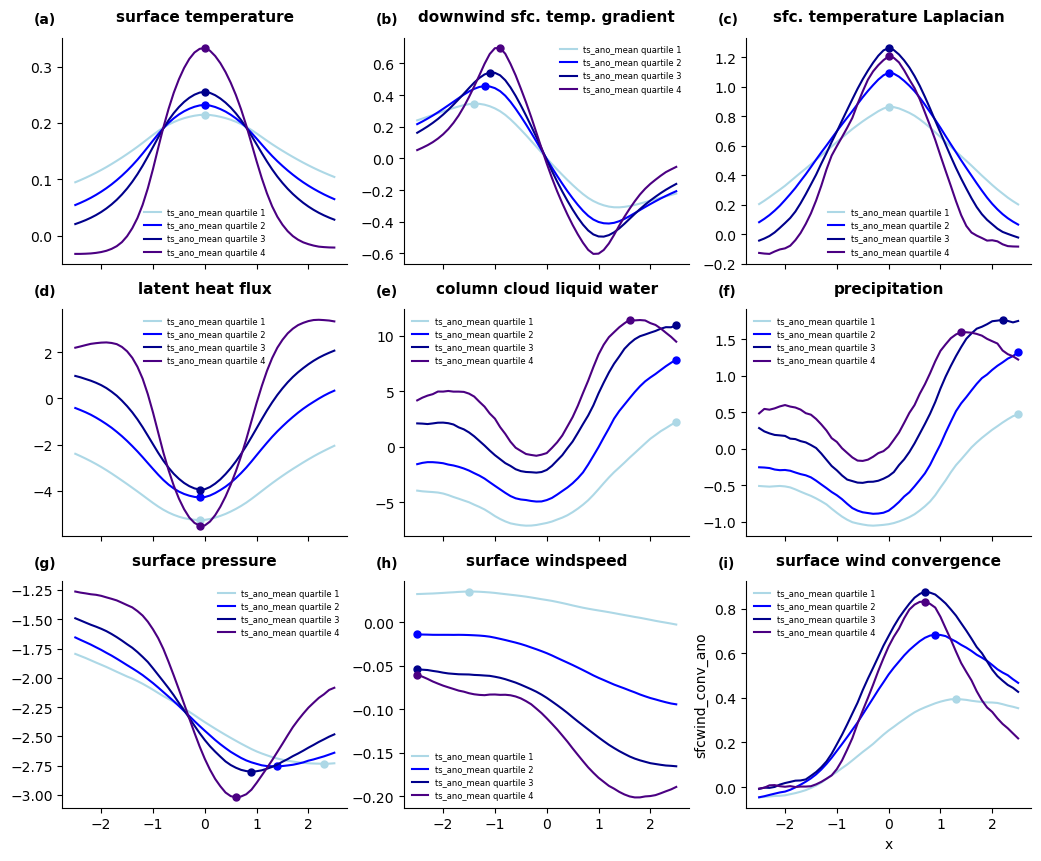

In [16]:
import hfplot.figure.figure as hffig
vars = [
    'ts_ano', 'downwind_ts_ano_grad', 'ts_ano_laplacian', 'hfls_ano',
    'cllvi_ano', 'pr_ano', 'ps_ano', 'sfcwind_ano', 'sfcwind_conv_ano',
    ]
var_group = 'ts_ano_mean'
colors = ['lightblue', 'blue', 'darkblue', 'indigo']

fig, axs = hffig.init_subfig(
    style=None, asprat=(12.5, 10), nrow=3, ncol=3, sharex=True, sharey=False,
    )
for v, var in enumerate(vars):
    for i in range(0, 4):
        compo_data = pccompo.adjust_units(
            alltrops_quartile_compo[var_group].sel(quartile=i+1), vars,
            ).sel(y=25)
        axs.ravel()[v].plot(
            compo_data['En_rota2_featcen_x'], compo_data[var],
            label=f'{var_group} quartile {i+1}', color=colors[i]
        )
        if var in ['hfls_ano', 'ps_ano']:
            axs.ravel()[v].plot(
                compo_data['En_rota2_featcen_x'].isel(
                    x=compo_data[var].argmin(dim='x').item()
                    ),
                compo_data[var].min(), '.', color=colors[i], markersize=10
                )
        else:
            axs.ravel()[v].plot(
                compo_data['En_rota2_featcen_x'].isel(
                    x=compo_data[var].argmax(dim='x').item()
                    ),
                compo_data[var].max(), '.', color=colors[i], markersize=10
                )
    axs.ravel()[v].set_title(
        pcplot.COMPO_PLOT_LABEL[var], weight='bold', pad=12, fontsize=11,
        )
    axs.ravel()[v].legend(frameon=False, fontsize=6)
plt.xlabel('x')
plt.ylabel(var)
plt.show()

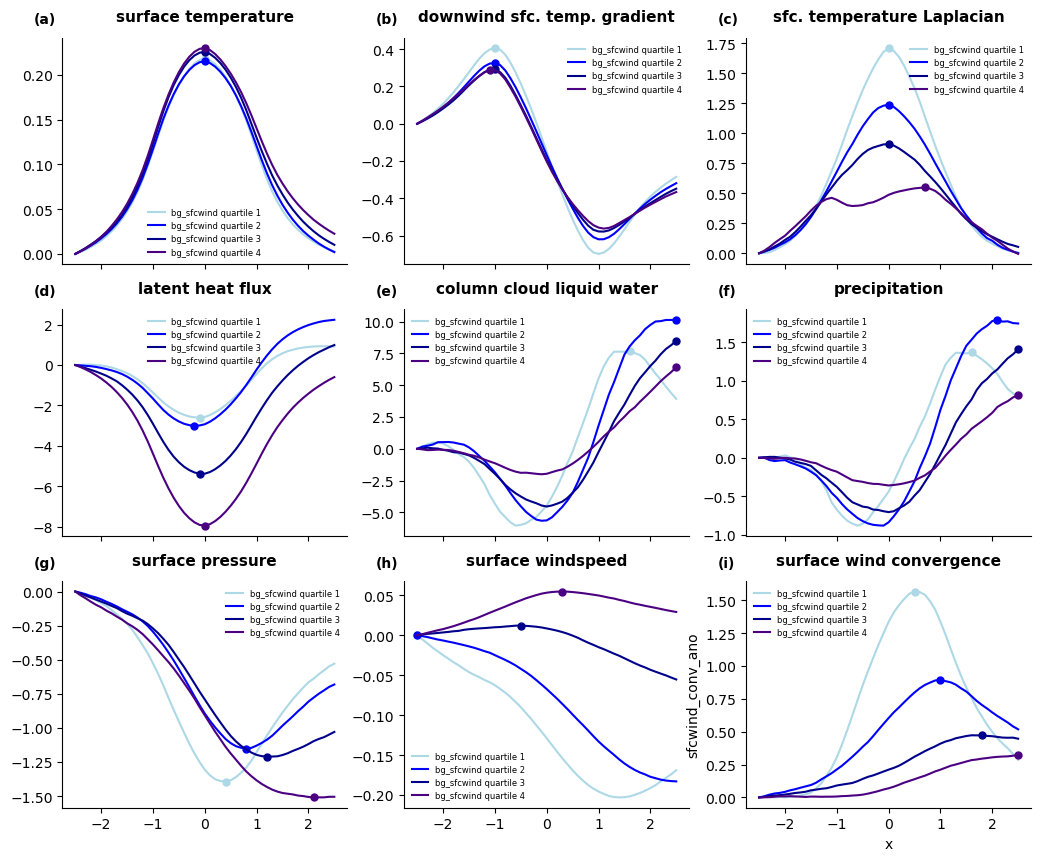

In [14]:
import hfplot.figure.figure as hffig
vars = [
    'ts_ano', 'downwind_ts_ano_grad', 'ts_ano_laplacian', 'hfls_ano',
    'cllvi_ano', 'pr_ano', 'ps_ano', 'sfcwind_ano', 'sfcwind_conv_ano',
    ]
var_group = 'bg_sfcwind'
colors = ['lightblue', 'blue', 'darkblue', 'indigo']

fig, axs = hffig.init_subfig(
    style=None, asprat=(12.5, 10), nrow=3, ncol=3, sharex=True, sharey=False,
    )
for v, var in enumerate(vars):
    for i in range(0, 4):
        compo_data = pccompo.adjust_units(
            alltrops_quartile_compo[var_group].sel(quartile=i+1), vars,
            ).sel(y=25)
        compo_data[var] = compo_data[var] - compo_data[var][0]
        axs.ravel()[v].plot(
            compo_data['En_rota2_featcen_x'], compo_data[var],
            label=f'{var_group} quartile {i+1}', color=colors[i]
        )
        if var in ['hfls_ano', 'ps_ano']:
            axs.ravel()[v].plot(
                compo_data['En_rota2_featcen_x'].isel(
                    x=compo_data[var].argmin(dim='x').item()
                    ),
                compo_data[var].min(), '.', color=colors[i], markersize=10
                )
        else:
            axs.ravel()[v].plot(
                compo_data['En_rota2_featcen_x'].isel(
                    x=compo_data[var].argmax(dim='x').item()
                    ),
                compo_data[var].max(), '.', color=colors[i], markersize=10
                )
    axs.ravel()[v].set_title(
        pcplot.COMPO_PLOT_LABEL[var], weight='bold', pad=12, fontsize=11,
        )
    axs.ravel()[v].legend(frameon=False, fontsize=6)
plt.xlabel('x')
plt.ylabel(var)
plt.show()

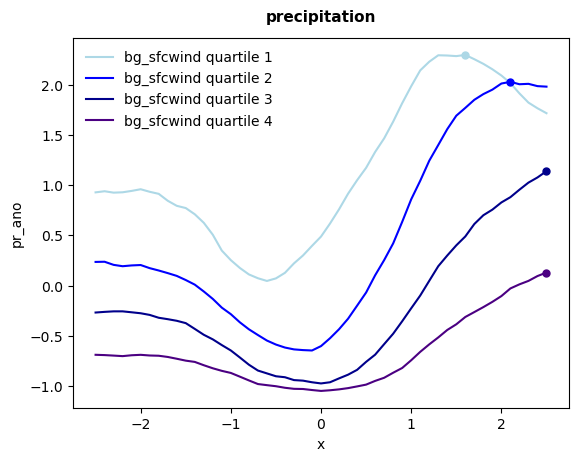

In [108]:
var = 'pr_ano'
colors = ['lightblue', 'blue', 'darkblue', 'indigo']
for i in range(0, 4):
    compo_data = pccompo.adjust_units(
        alltrops_quartile_compo['bg_sfcwind'].sel(quartile=i+1), vars,
        ).sel(y=25)
    plt.plot(
        compo_data['En_rota2_featcen_x'], compo_data[var],
        label=f'bg_sfcwind quartile {i+1}', color=colors[i]
    )
    plt.plot(
        compo_data['En_rota2_featcen_x'].isel(x=compo_data[var].argmax(dim='x').item()),
        compo_data[var].max(), '.', color=colors[i], markersize=10
        )
plt.gca().set_title(
    pcplot.COMPO_PLOT_LABEL[var], weight='bold', pad=12, fontsize=11,
    )
plt.legend(frameon=False)
plt.xlabel('x')
plt.ylabel(var)
plt.show()

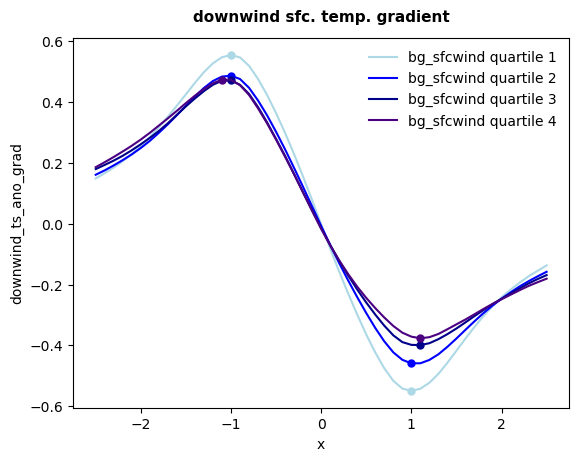

In [120]:
var = 'downwind_ts_ano_grad'
colors = ['lightblue', 'blue', 'darkblue', 'indigo']
for i in range(0, 4):
    compo_data = pccompo.adjust_units(
        alltrops_quartile_compo['bg_sfcwind'].sel(quartile=i+1), vars,
        ).sel(y=25)
    plt.plot(
        compo_data['En_rota2_featcen_x'], compo_data[var],
        label=f'bg_sfcwind quartile {i+1}', color=colors[i]
    )
    plt.plot(
        compo_data['En_rota2_featcen_x'].isel(x=compo_data[var].argmax(dim='x').item()),
        compo_data[var].max(), '.', color=colors[i], markersize=10
        )
    plt.plot(
        compo_data['En_rota2_featcen_x'].isel(x=compo_data[var].argmin(dim='x').item()),
        compo_data[var].min(), '.', color=colors[i], markersize=10
        )
plt.gca().set_title(
    pcplot.COMPO_PLOT_LABEL[var], weight='bold', pad=12, fontsize=11,
    )
plt.legend(frameon=False)
plt.xlabel('x')
plt.ylabel(var)
plt.show()

### Plot rainbelt subsampling mask

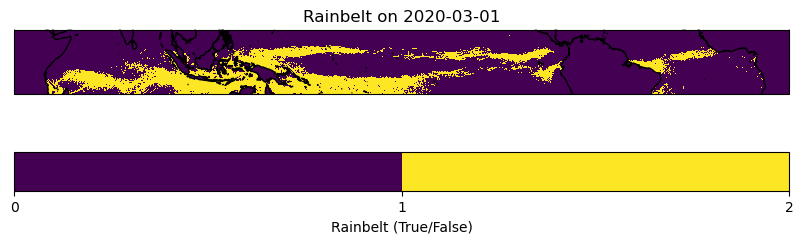

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-155))
rainbelt.sel(time=feature['time']).plot(
    ax=ax, transform=ccrs.PlateCarree(),
    levels=[0, 1, 2],
    cbar_kwargs={'label': 'Rainbelt (True/False)', 'orientation': 'horizontal'}
)
ax.coastlines()
ax.set_title(f"Rainbelt on {str(feature['time'].values)[:10]}")
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-155))
pr_clim.sel(time=feature['time']).plot(
    ax=ax, transform=ccrs.PlateCarree(), 
    cbar_kwargs={'label': 'Pr (mm/day)', 'orientation': 'horizontal'},
    levels=np.arange(0,21,2)
)
ax.coastlines()
ax.set_title(f"Rainbelt on {str(feature['time'].values)[:10]}")
plt.show()